***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 4_2</span> 

# Helmholtz Machine on Self-organizing System (Expansion on Exploration)

In this notebook we simulate the evolution of a self-organizing system by the training of the Helmholtz machine. By increasing the length of input layer from 10 to 12, we expanded the space from 1024 categories to 4096, which is way more difficult to fit and manipulate. Instead of fitting a given dataset, which presents bad performance with an accuracy of $0.22$ only, we construct a self-organizing system to guide the model to explore the large space by its own Helmholtz device, which expands its evidence by its self-guided exploration gradually, with steady improvement on generation accuracy and distribution error. 

*Experimental setup*: we start from a small randomly sampled set (100 datapoints) as the initial data input, then by the free sampling of the generative side of the Helmholtz machine, we add its frequently sampled new instances to the dataset to expand its evidence support. This process takes place gradually, with a few "new findings of exploration" added after every 100 epochs. In the meantime, the system keeps fitting to its current evidence by training under the wake-sleep algorithm. After a long period of thus back and forth on exploration and exploitation, the system is fitted quite well to its own constructed subspace (niche), with an accuracy of $0.82$ and distribution error $0.29$ (see the visualization below).

<img src="self organizing result.png" style="width:800px">
<caption><center> Self-organizing System Training Result    </center></caption>

*Created:* December 26, 2023

*Updated:* December 26, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [2]:
structure = [[12,10,8,7,5,4,3,1]]
n_dz = np.array(structure)
n_dz

array([[12, 10,  8,  7,  5,  4,  3,  1]])

In [60]:
Phi, Theta = ut.parameter_initialization("zero",n_dz)  # "zero" or "random"

In [3]:
value_set = [1,0]
activation_type = "tanh"
bias = [False,False,True] # [instantiation bias, MLP bias,data bias]

In [62]:
n_sample = 100
init_generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
init_generation

array([[0., 0., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [63]:
dataset = np.unique(init_generation,axis=1)
dataset.shape

(12, 99)

In [19]:
entire_set = ut.all_comb(n, value_set)
reordered_set = ut.reorder_all_comb(entire_set,dataset)

Self-organizing System:

In [274]:
lr = 0.008
epoch = 10
n = n_dz[0,0]
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [275]:
update_rate = 100 # after how many epochs we update evidence
n_add_sample = 560 # how many new samples to add at each update

In [276]:
for e in range(epoch):
    new_sampled = np.zeros((n,n_data*update_rate))
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for r in range (update_rate):
        index = np.random.permutation(n_data)
        for i in range(n_data):
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
            Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
            Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
            Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)

            new_sampled[:,i+n_data*r:i+n_data*r+1] = Alpha_P['z0']

            Loss_Q_total += Loss_Q
            Loss_P_total += Loss_P

    values,counts = np.unique(new_sampled,axis=1,return_counts = True)
    n_new_total = np.unique(np.append(dataset,values,axis=1),axis=1).shape[1] - n_data
    
    new_samples = values[:,np.argsort(counts)[-n_add_sample:]]
    dataset = np.unique(np.append(dataset,new_samples,axis=1),axis=1)  # renew dataset
    n_data = dataset.shape[1]

    Loss_Q_total = Loss_Q_total/(n_data*update_rate)
    Loss_P_total = Loss_P_total/(n_data*update_rate)
    print('Total new sampled: ' + str(n_new_total),'dataset size: ' + str(n_data),'Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Total new sampled: 2517 dataset size: 679 Loss_Q: [1.96 1.87 2.27 1.42 1.14 0.69 0.   9.35] Loss_P: [ 3.18  2.54  2.27  2.54  1.4   1.12  1.07 14.12]
Total new sampled: 2541 dataset size: 680 Loss_Q: [1.93 1.88 2.22 1.4  1.12 0.66 0.   9.21] Loss_P: [ 3.16  2.55  2.26  2.45  1.43  1.08  1.02 13.95]
Total new sampled: 2551 dataset size: 680 Loss_Q: [1.85 1.8  2.27 1.56 1.15 0.72 0.   9.36] Loss_P: [ 3.18  2.46  2.18  2.52  1.6   1.11  1.08 14.13]
Total new sampled: 2518 dataset size: 680 Loss_Q: [1.9  1.83 2.25 1.64 1.22 0.73 0.   9.57] Loss_P: [ 3.17  2.51  2.2   2.53  1.65  1.2   1.09 14.35]
Total new sampled: 2554 dataset size: 680 Loss_Q: [1.92 1.82 2.27 1.65 1.2  0.69 0.   9.55] Loss_P: [ 3.17  2.51  2.23  2.56  1.65  1.15  1.03 14.31]
Total new sampled: 2545 dataset size: 680 Loss_Q: [1.98 1.88 2.37 1.68 1.23 0.73 0.   9.87] Loss_P: [ 3.13  2.57  2.34  2.67  1.68  1.17  1.08 14.64]
Total new sampled: 2528 dataset size: 682 Loss_Q: [1.89 2.   2.36 1.65 1.26 0.77 0.   9.93] Loss_P: 

246, 281,338,340,379,394,432,464,476,484,523,569,586,621,623,627,656,672,678,685

In [287]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
generation

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])

In [288]:
reordered_set = ut.reorder_all_comb(entire_set,dataset)
distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*n_data

In [289]:
ABS_Error

0.4246129186602871

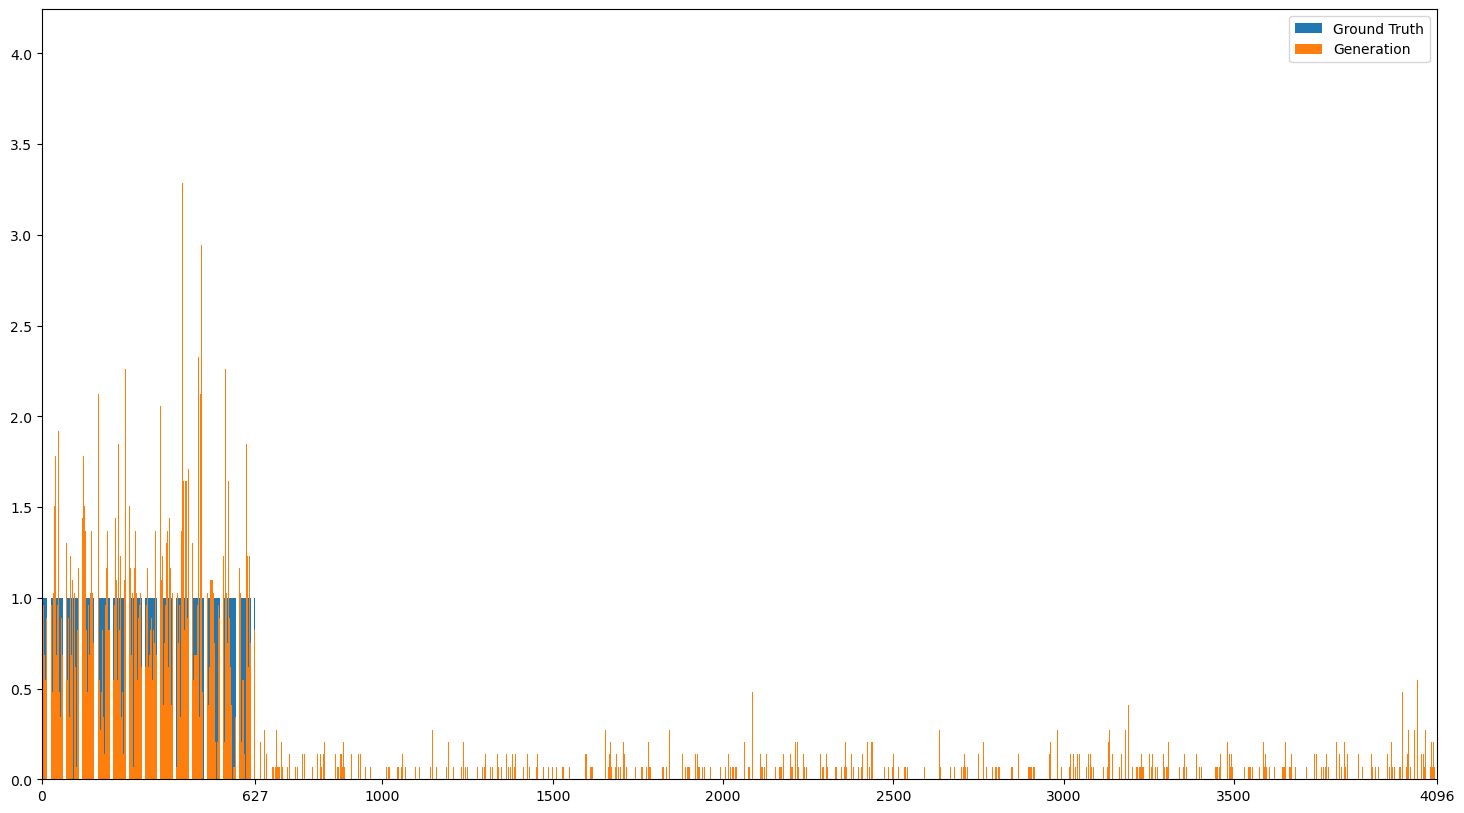

In [290]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [291]:
statistics

{'percent': 0.8111,
 'FN': array([ 38,  93,  98, 123, 171, 233, 241, 297, 332, 471, 475, 481, 483,
        493, 494, 513, 514, 515, 531, 549, 555, 560, 562, 567, 572, 574,
        577, 594, 598, 600, 618, 620, 625]),
 'n_fn': 33,
 'FP': array([[ 628,  629,  634, ..., 4091, 4093, 4094],
        [   1,    1,    1, ...,    2,    2,    3]], dtype=int64),
 'n_fp': 1184}

In [292]:
MSE

0.28733247

'percent': 0.5393,0.6233, 0.6112,0.6729,0.6763,0.6908, 0.7262,0.7372,0.7601,0.7958,0.795,0.8092,0.8307,0.8224,0.8111

n_fn': 17,19,11,23,23,27,23,26,28,32,36,36,38,37,33

'n_fp': 1791,1593,1634,1486,1470,1402,1352,1276,1292,1181,1221,1132,1060,1087,1184

MSE: 0.4562,0.4149,0.3870,0.4085,0.3982,0.3602,0.3329,0.3132,0.3042,0.3093,0.3055,0.2850,0.3021,0.2917,0.2873

Save dataset, parameters!

In [245]:
np.unique(dataset,axis=1).shape

(12, 627)

In [246]:
np.save('self_org_dataset.npy',dataset)

In [247]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [249]:
np.save('self_org_parameters.npy',parameters)

In [283]:
para = np.load('self_org_parameters.npy',allow_pickle=True).item()

In [284]:
Theta = para['Theta']

In [285]:
dataset = np.load('self_org_dataset.npy')

A Test we can do now is to fit a default Helmholtz machine (initialized to 0) of same structure to this self-constructed dataset and see how well it could perform.

In [338]:
Phi, Theta = ut.parameter_initialization("random",n_dz)

In [339]:
reordered_set = ut.reorder_all_comb(entire_set,dataset)

In [340]:
lr = 0.015
epoch = 1000
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [341]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
        Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Loss_Q: [ 4.18  3.34  2.96  2.25  1.79  1.32  0.   15.83] Loss_P: [ 5.04  4.27  3.37  3.09  2.25  1.8   1.43 21.25]
Loss_Q: [ 3.74  3.1   2.81  2.17  1.72  1.23  0.   14.77] Loss_P: [ 4.56  3.86  3.24  3.06  2.17  1.79  1.34 20.02]
Loss_Q: [ 3.57  3.02  2.75  2.2   1.69  1.24  0.   14.48] Loss_P: [ 4.44  3.74  3.15  2.96  2.26  1.76  1.35 19.65]
Loss_Q: [ 3.52  2.99  2.7   2.21  1.64  1.27  0.   14.32] Loss_P: [ 4.38  3.82  3.05  2.95  2.22  1.77  1.38 19.58]
Loss_Q: [ 3.47  2.96  2.75  2.16  1.7   1.27  0.   14.31] Loss_P: [ 4.35  3.74  3.08  3.    2.18  1.79  1.39 19.53]
Loss_Q: [ 3.43  2.97  2.66  2.13  1.7   1.27  0.   14.17] Loss_P: [ 4.31  3.67  3.04  2.93  2.2   1.8   1.37 19.33]
Loss_Q: [ 3.41  2.92  2.72  2.16  1.69  1.22  0.   14.12] Loss_P: [ 4.32  3.65  3.04  2.94  2.19  1.81  1.33 19.27]
Loss_Q: [ 3.39  2.93  2.7   2.07  1.71  1.24  0.   14.05] Loss_P: [ 4.26  3.7   3.06  2.96  2.11  1.82  1.32 19.24]
Loss_Q: [ 3.4   2.98  2.75  2.05  1.72  1.24  0.   14.13] Loss_P: [ 4.22

Loss_Q: [ 2.91  2.89  2.57  1.87  1.47  1.08  0.   12.8 ] Loss_P: [ 3.77  3.42  3.06  2.73  2.08  1.52  1.17 17.74]
Loss_Q: [ 2.99  2.91  2.46  1.86  1.48  1.08  0.   12.79] Loss_P: [ 3.76  3.48  3.06  2.68  2.05  1.5   1.17 17.69]
Loss_Q: [ 2.94  2.86  2.47  1.97  1.54  1.09  0.   12.87] Loss_P: [ 3.77  3.48  3.03  2.62  2.13  1.6   1.16 17.81]
Loss_Q: [ 3.05  2.8   2.44  2.    1.61  1.08  0.   12.97] Loss_P: [ 3.77  3.5   2.97  2.65  2.19  1.65  1.18 17.91]
Loss_Q: [ 2.99  2.83  2.47  2.01  1.65  1.05  0.   12.99] Loss_P: [ 3.74  3.4   2.93  2.61  2.2   1.71  1.16 17.74]
Loss_Q: [ 2.91  2.79  2.53  1.93  1.67  1.07  0.   12.92] Loss_P: [ 3.76  3.48  2.93  2.69  2.15  1.7   1.16 17.87]
Loss_Q: [ 2.87  2.85  2.52  1.92  1.68  1.12  0.   12.96] Loss_P: [ 3.79  3.35  3.    2.66  2.1   1.69  1.19 17.79]
Loss_Q: [ 2.89  2.95  2.59  1.98  1.7   1.12  0.   13.23] Loss_P: [ 3.76  3.36  3.08  2.72  2.17  1.75  1.19 18.04]
Loss_Q: [ 3.04  2.94  2.62  1.98  1.72  1.08  0.   13.37] Loss_P: [ 3.77

Loss_Q: [ 2.66  2.76  2.32  1.89  1.66  1.13  0.   12.42] Loss_P: [ 3.7   3.12  2.86  2.5   2.18  1.72  1.25 17.32]
Loss_Q: [ 2.65  2.7   2.3   1.9   1.69  1.13  0.   12.37] Loss_P: [ 3.66  3.16  2.76  2.45  2.19  1.71  1.21 17.14]
Loss_Q: [ 2.69  2.71  2.31  1.91  1.7   1.08  0.   12.41] Loss_P: [ 3.67  3.22  2.78  2.48  2.17  1.72  1.2  17.24]
Loss_Q: [ 2.74  2.68  2.29  1.87  1.66  1.05  0.   12.29] Loss_P: [ 3.67  3.2   2.84  2.46  2.12  1.73  1.12 17.13]
Loss_Q: [ 2.67  2.75  2.25  1.85  1.67  1.08  0.   12.27] Loss_P: [ 3.61  3.17  2.9   2.43  2.14  1.68  1.19 17.12]
Loss_Q: [ 2.72  2.82  2.28  1.81  1.69  1.08  0.   12.39] Loss_P: [ 3.65  3.2   2.95  2.46  2.12  1.69  1.19 17.26]
Loss_Q: [ 2.69  2.82  2.24  1.86  1.67  1.07  0.   12.35] Loss_P: [ 3.65  3.18  2.93  2.39  2.14  1.69  1.16 17.14]
Loss_Q: [ 2.68  2.85  2.3   1.86  1.64  1.05  0.   12.38] Loss_P: [ 3.61  3.21  2.95  2.43  2.14  1.7   1.12 17.16]
Loss_Q: [ 2.74  2.84  2.3   1.83  1.64  0.95  0.   12.3 ] Loss_P: [ 3.59

Loss_Q: [ 2.49  2.67  2.26  1.73  1.64  1.13  0.   11.92] Loss_P: [ 3.44  3.11  2.86  2.5   1.95  1.72  1.21 16.78]
Loss_Q: [ 2.5   2.64  2.25  1.74  1.6   1.13  0.   11.86] Loss_P: [ 3.45  3.09  2.82  2.46  1.97  1.68  1.26 16.72]
Loss_Q: [ 2.48  2.62  2.26  1.73  1.61  1.18  0.   11.89] Loss_P: [ 3.47  3.09  2.77  2.46  1.94  1.68  1.26 16.67]
Loss_Q: [ 2.51  2.6   2.28  1.7   1.65  1.23  0.   11.97] Loss_P: [ 3.45  3.08  2.82  2.51  1.94  1.71  1.33 16.84]
Loss_Q: [ 2.49  2.65  2.32  1.7   1.61  1.19  0.   11.96] Loss_P: [ 3.48  3.18  2.85  2.46  2.    1.7   1.28 16.95]
Loss_Q: [ 2.44  2.61  2.35  1.71  1.6   1.22  0.   11.93] Loss_P: [ 3.43  3.15  2.85  2.51  1.97  1.66  1.28 16.84]
Loss_Q: [ 2.45  2.58  2.22  1.69  1.59  1.2   0.   11.74] Loss_P: [ 3.43  3.12  2.8   2.49  2.01  1.68  1.29 16.82]
Loss_Q: [ 2.47  2.63  2.19  1.73  1.57  1.17  0.   11.76] Loss_P: [ 3.4   3.09  2.74  2.33  1.95  1.66  1.27 16.45]
Loss_Q: [ 2.39  2.58  2.16  1.71  1.57  1.15  0.   11.56] Loss_P: [ 3.49

Loss_Q: [ 2.04  2.2   2.19  1.65  1.46  1.08  0.   10.62] Loss_P: [ 3.53  2.71  2.45  2.31  1.78  1.55  1.17 15.49]
Loss_Q: [ 2.19  2.26  2.19  1.61  1.48  1.03  0.   10.75] Loss_P: [ 3.52  2.83  2.52  2.26  1.77  1.55  1.23 15.69]
Loss_Q: [ 2.18  2.21  2.23  1.62  1.51  1.08  0.   10.83] Loss_P: [ 3.49  2.8   2.46  2.35  1.8   1.55  1.27 15.73]
Loss_Q: [ 2.25  2.34  2.31  1.72  1.52  1.13  0.   11.27] Loss_P: [ 3.49  2.84  2.6   2.41  1.85  1.54  1.25 15.96]
Loss_Q: [ 2.25  2.29  2.4   1.75  1.47  1.12  0.   11.28] Loss_P: [ 3.49  2.84  2.63  2.47  1.87  1.55  1.26 16.12]
Loss_Q: [ 2.25  2.27  2.34  1.73  1.5   1.1   0.   11.18] Loss_P: [ 3.49  2.94  2.59  2.53  1.88  1.62  1.25 16.3 ]
Loss_Q: [ 2.28  2.25  2.28  1.71  1.53  1.14  0.   11.18] Loss_P: [ 3.49  2.88  2.55  2.4   1.91  1.59  1.26 16.08]
Loss_Q: [ 2.24  2.27  2.29  1.76  1.49  1.06  0.   11.1 ] Loss_P: [ 3.53  2.8   2.55  2.4   1.93  1.57  1.23 16.02]
Loss_Q: [ 2.22  2.26  2.27  1.82  1.59  1.13  0.   11.29] Loss_P: [ 3.52

Loss_Q: [1.98 2.21 1.9  1.72 1.34 0.76 0.   9.91] Loss_P: [ 3.46  2.5   2.58  1.92  1.96  1.39  0.9  14.71]
Loss_Q: [1.94 2.24 1.87 1.69 1.37 0.78 0.   9.89] Loss_P: [ 3.44  2.52  2.51  1.96  1.97  1.4   0.9  14.71]
Loss_Q: [1.98 2.23 1.87 1.74 1.36 0.73 0.   9.92] Loss_P: [ 3.43  2.54  2.46  1.87  1.94  1.38  0.85 14.47]
Loss_Q: [1.94 2.18 1.91 1.72 1.34 0.71 0.   9.8 ] Loss_P: [ 3.42  2.58  2.5   2.01  1.94  1.38  0.85 14.68]
Loss_Q: [1.93 2.18 1.91 1.74 1.34 0.77 0.   9.87] Loss_P: [ 3.41  2.5   2.44  2.01  1.98  1.42  0.86 14.63]
Loss_Q: [1.92 2.19 2.01 1.75 1.34 0.75 0.   9.96] Loss_P: [ 3.4   2.49  2.45  2.05  2.02  1.36  0.84 14.62]
Loss_Q: [1.99 2.13 1.99 1.7  1.3  0.75 0.   9.86] Loss_P: [ 3.39  2.55  2.32  2.01  1.98  1.31  0.86 14.42]
Loss_Q: [1.91 2.08 1.92 1.72 1.31 0.77 0.   9.71] Loss_P: [ 3.4   2.54  2.37  1.98  2.    1.31  0.9  14.5 ]
Loss_Q: [1.86 2.09 1.82 1.75 1.24 0.77 0.   9.53] Loss_P: [ 3.44  2.51  2.39  1.88  2.04  1.26  0.92 14.43]
Loss_Q: [1.84 2.13 1.88 1.74

Loss_Q: [2.08 2.52 1.92 1.65 1.12 0.68 0.   9.96] Loss_P: [ 3.33  2.64  2.72  2.14  1.81  1.12  0.89 14.65]
Loss_Q: [1.99 2.47 2.01 1.62 1.16 0.68 0.   9.94] Loss_P: [ 3.36  2.66  2.69  2.17  1.76  1.15  0.9  14.69]
Loss_Q: [2.01 2.44 2.03 1.63 1.14 0.68 0.   9.93] Loss_P: [ 3.35  2.64  2.66  2.19  1.83  1.14  0.9  14.7 ]
Loss_Q: [1.97 2.41 1.99 1.57 1.12 0.65 0.   9.7 ] Loss_P: [ 3.38  2.59  2.68  2.18  1.78  1.09  0.86 14.56]
Loss_Q: [2.01 2.56 1.99 1.61 1.06 0.66 0.   9.89] Loss_P: [ 3.35  2.69  2.73  2.19  1.76  1.08  0.8  14.59]
Loss_Q: [2.   2.53 1.96 1.6  1.09 0.64 0.   9.81] Loss_P: [ 3.36  2.65  2.69  2.16  1.77  1.08  0.83 14.53]
Loss_Q: [2.02 2.49 1.97 1.62 1.14 0.66 0.   9.9 ] Loss_P: [ 3.34  2.64  2.66  2.24  1.8   1.14  0.89 14.71]
Loss_Q: [2.03 2.43 2.03 1.63 1.14 0.64 0.   9.9 ] Loss_P: [ 3.34  2.69  2.67  2.17  1.82  1.13  0.88 14.71]
Loss_Q: [ 2.07  2.53  2.03  1.71  1.15  0.69  0.   10.17] Loss_P: [ 3.35  2.69  2.72  2.23  1.84  1.14  0.89 14.87]
Loss_Q: [ 1.94  2.47

Loss_Q: [ 2.1   2.17  2.33  1.75  1.06  0.7   0.   10.12] Loss_P: [ 3.24  2.86  2.52  2.48  1.93  1.09  0.91 15.03]
Loss_Q: [ 2.1   2.25  2.26  1.73  1.15  0.73  0.   10.21] Loss_P: [ 3.24  2.85  2.55  2.36  1.95  1.08  0.94 14.97]
Loss_Q: [2.07 2.19 2.19 1.79 1.08 0.64 0.   9.96] Loss_P: [ 3.21  2.72  2.48  2.3   1.93  1.07  0.88 14.58]
Loss_Q: [2.07 2.18 2.24 1.78 1.06 0.64 0.   9.97] Loss_P: [ 3.23  2.77  2.53  2.37  1.97  1.04  0.87 14.77]
Loss_Q: [ 2.14  2.25  2.22  1.83  1.03  0.68  0.   10.16] Loss_P: [ 3.25  2.81  2.62  2.39  2.    1.07  0.9  15.05]
Loss_Q: [ 2.19  2.33  2.21  1.84  1.09  0.71  0.   10.37] Loss_P: [ 3.23  2.87  2.65  2.28  1.95  1.05  0.89 14.92]
Loss_Q: [ 2.21  2.31  2.14  1.85  1.05  0.68  0.   10.22] Loss_P: [ 3.23  2.91  2.62  2.26  2.05  0.99  0.87 14.92]
Loss_Q: [ 2.16  2.31  2.11  1.84  1.07  0.7   0.   10.19] Loss_P: [ 3.23  2.89  2.62  2.24  2.05  1.05  0.91 15.  ]
Loss_Q: [ 2.19  2.26  2.13  1.82  1.05  0.65  0.   10.09] Loss_P: [ 3.22  2.85  2.61  2.

Loss_Q: [ 2.13  2.47  2.24  1.73  1.17  0.73  0.   10.48] Loss_P: [ 3.33  2.81  2.73  2.42  1.94  1.13  0.97 15.33]
Loss_Q: [ 2.11  2.57  2.26  1.82  1.19  0.71  0.   10.65] Loss_P: [ 3.28  2.71  2.82  2.46  1.95  1.17  0.98 15.37]
Loss_Q: [ 1.9   2.6   2.26  1.76  1.16  0.79  0.   10.47] Loss_P: [ 3.29  2.63  2.88  2.43  1.92  1.16  1.   15.31]
Loss_Q: [ 2.09  2.47  2.25  1.77  1.18  0.76  0.   10.52] Loss_P: [ 3.31  2.69  2.81  2.45  1.91  1.15  1.01 15.33]
Loss_Q: [ 2.08  2.52  2.34  1.84  1.25  0.74  0.   10.76] Loss_P: [ 3.29  2.81  2.81  2.46  2.02  1.2   0.99 15.57]
Loss_Q: [ 2.18  2.5   2.29  1.85  1.26  0.75  0.   10.82] Loss_P: [ 3.23  2.89  2.74  2.49  1.99  1.26  0.96 15.56]
Loss_Q: [ 2.11  2.38  2.26  1.75  1.28  0.71  0.   10.49] Loss_P: [ 3.26  2.86  2.65  2.44  1.89  1.26  0.96 15.31]
Loss_Q: [ 2.12  2.35  2.32  1.78  1.28  0.75  0.   10.61] Loss_P: [ 3.27  2.75  2.69  2.52  1.9   1.18  0.98 15.28]
Loss_Q: [ 2.09  2.39  2.26  1.72  1.26  0.82  0.   10.54] Loss_P: [ 3.28

Loss_Q: [ 1.98  2.27  2.15  1.9   1.18  0.68  0.   10.16] Loss_P: [ 3.32  2.56  2.62  2.35  2.01  1.18  0.94 14.99]
Loss_Q: [ 1.92  2.29  2.17  1.87  1.25  0.69  0.   10.18] Loss_P: [ 3.3   2.49  2.7   2.33  1.99  1.21  0.98 15.01]
Loss_Q: [ 1.99  2.3   2.18  1.92  1.25  0.77  0.   10.4 ] Loss_P: [ 3.27  2.58  2.74  2.34  2.02  1.15  1.03 15.14]
Loss_Q: [ 1.97  2.29  2.25  1.94  1.27  0.72  0.   10.44] Loss_P: [ 3.3   2.66  2.64  2.35  2.03  1.19  1.03 15.21]
Loss_Q: [ 2.01  2.28  2.17  1.89  1.27  0.75  0.   10.37] Loss_P: [ 3.29  2.65  2.63  2.29  2.06  1.18  1.   15.11]
Loss_Q: [ 1.95  2.2   2.08  1.91  1.27  0.77  0.   10.17] Loss_P: [ 3.34  2.55  2.55  2.2   2.04  1.19  1.03 14.9 ]
Loss_Q: [1.82 2.2  2.03 1.87 1.29 0.73 0.   9.93] Loss_P: [ 3.34  2.55  2.59  2.09  1.99  1.17  1.04 14.77]
Loss_Q: [ 1.91  2.23  2.01  1.89  1.25  0.73  0.   10.02] Loss_P: [ 3.32  2.52  2.68  2.14  2.    1.12  1.04 14.82]
Loss_Q: [ 1.83  2.28  2.04  1.87  1.22  0.76  0.   10.01] Loss_P: [ 3.38  2.43  

Loss_Q: [2.08 2.16 2.16 1.78 0.88 0.78 0.   9.83] Loss_P: [ 3.26  2.72  2.53  2.32  1.84  0.84  1.04 14.55]
Loss_Q: [2.   2.1  2.21 1.69 0.88 0.79 0.   9.67] Loss_P: [ 3.34  2.63  2.43  2.33  1.8   0.81  1.   14.34]
Loss_Q: [1.92 2.   2.25 1.65 0.82 0.71 0.   9.35] Loss_P: [ 3.28  2.62  2.39  2.39  1.8   0.83  0.95 14.27]
Loss_Q: [2.02 1.98 2.36 1.66 0.85 0.72 0.   9.59] Loss_P: [ 3.27  2.67  2.39  2.43  1.78  0.77  0.93 14.24]
Loss_Q: [2.04 2.09 2.33 1.63 0.77 0.7  0.   9.56] Loss_P: [ 3.31  2.74  2.45  2.47  1.74  0.72  0.89 14.33]
Loss_Q: [1.96 2.07 2.36 1.66 0.81 0.72 0.   9.59] Loss_P: [ 3.35  2.62  2.52  2.51  1.81  0.77  0.92 14.52]
Loss_Q: [1.99 2.11 2.39 1.75 0.94 0.72 0.   9.9 ] Loss_P: [ 3.29  2.62  2.44  2.47  1.87  0.89  0.96 14.52]
Loss_Q: [1.95 1.97 2.32 1.7  0.93 0.75 0.   9.62] Loss_P: [ 3.3   2.64  2.47  2.48  1.82  0.89  0.96 14.57]
Loss_Q: [1.98 1.97 2.28 1.83 0.94 0.76 0.   9.76] Loss_P: [ 3.29  2.65  2.35  2.42  1.88  0.91  1.   14.5 ]
Loss_Q: [1.97 1.95 2.28 1.81

Loss_Q: [ 2.1   2.08  2.3   1.81  1.24  0.83  0.   10.35] Loss_P: [ 3.26  2.63  2.4   2.52  1.84  1.14  1.15 14.94]
Loss_Q: [ 2.    2.17  2.37  1.81  1.25  0.86  0.   10.46] Loss_P: [ 3.25  2.66  2.48  2.57  1.84  1.17  1.21 15.19]
Loss_Q: [ 2.06  2.18  2.37  1.84  1.23  0.87  0.   10.55] Loss_P: [ 3.28  2.67  2.45  2.58  1.84  1.15  1.16 15.12]
Loss_Q: [ 2.05  2.18  2.37  1.78  1.18  0.84  0.   10.39] Loss_P: [ 3.26  2.67  2.54  2.6   1.85  1.07  1.14 15.13]
Loss_Q: [ 2.03  2.17  2.38  1.8   1.15  0.83  0.   10.36] Loss_P: [ 3.31  2.63  2.5   2.54  1.8   1.08  1.13 14.99]
Loss_Q: [ 2.06  2.13  2.45  1.81  1.18  0.77  0.   10.41] Loss_P: [ 3.28  2.64  2.45  2.57  1.85  1.07  1.11 14.97]
Loss_Q: [ 2.02  2.11  2.42  1.79  1.17  0.77  0.   10.28] Loss_P: [ 3.23  2.63  2.49  2.6   1.9   1.06  1.05 14.96]
Loss_Q: [ 2.02  2.08  2.37  1.83  1.17  0.74  0.   10.22] Loss_P: [ 3.28  2.61  2.47  2.6   1.87  1.11  1.06 15.01]
Loss_Q: [ 2.03  2.1   2.35  1.83  1.14  0.79  0.   10.25] Loss_P: [ 3.27

Loss_Q: [2.03 2.02 2.17 1.77 1.27 0.55 0.   9.8 ] Loss_P: [ 3.26  2.7   2.47  2.28  1.88  1.22  0.74 14.56]
Loss_Q: [2.1  2.02 2.22 1.78 1.28 0.54 0.   9.94] Loss_P: [ 3.22  2.84  2.48  2.32  1.87  1.17  0.72 14.61]
Loss_Q: [2.05 2.01 2.15 1.76 1.3  0.51 0.   9.78] Loss_P: [ 3.23  2.73  2.51  2.29  1.86  1.22  0.7  14.53]
Loss_Q: [2.14 2.01 2.18 1.73 1.29 0.52 0.   9.87] Loss_P: [ 3.21  2.77  2.53  2.33  1.89  1.21  0.71 14.66]
Loss_Q: [2.02 2.01 2.16 1.8  1.28 0.51 0.   9.78] Loss_P: [ 3.25  2.64  2.51  2.35  1.92  1.18  0.75 14.6 ]
Loss_Q: [2.03 1.97 2.09 1.76 1.27 0.53 0.   9.65] Loss_P: [ 3.22  2.72  2.42  2.22  1.82  1.18  0.69 14.28]
Loss_Q: [1.92 1.98 2.03 1.74 1.27 0.56 0.   9.5 ] Loss_P: [ 3.25  2.65  2.4   2.22  1.82  1.19  0.72 14.24]
Loss_Q: [1.9  1.94 2.01 1.75 1.29 0.54 0.   9.43] Loss_P: [ 3.24  2.63  2.39  2.17  1.86  1.16  0.76 14.2 ]
Loss_Q: [2.04 2.03 1.99 1.77 1.23 0.6  0.   9.66] Loss_P: [ 3.26  2.66  2.47  2.15  1.9   1.13  0.8  14.37]
Loss_Q: [2.02 2.06 1.96 1.83

Loss_Q: [1.71 1.87 2.16 1.55 1.07 0.54 0.   8.91] Loss_P: [ 3.29  2.36  2.26  2.28  1.63  1.02  0.73 13.57]
Loss_Q: [1.71 1.81 2.13 1.54 1.12 0.54 0.   8.85] Loss_P: [ 3.29  2.36  2.21  2.3   1.58  1.01  0.72 13.47]
Loss_Q: [1.71 1.74 2.06 1.5  1.11 0.55 0.   8.67] Loss_P: [ 3.33  2.34  2.17  2.19  1.54  1.04  0.77 13.37]
Loss_Q: [1.65 1.73 2.07 1.51 1.15 0.55 0.   8.67] Loss_P: [ 3.33  2.31  2.1   2.27  1.57  1.12  0.79 13.5 ]
Loss_Q: [1.66 1.82 2.09 1.5  1.14 0.57 0.   8.78] Loss_P: [ 3.28  2.28  2.17  2.29  1.56  1.14  0.78 13.5 ]
Loss_Q: [1.62 1.81 2.15 1.56 1.12 0.62 0.   8.88] Loss_P: [ 3.36  2.26  2.15  2.31  1.62  1.07  0.8  13.57]
Loss_Q: [1.68 1.86 2.18 1.57 1.1  0.65 0.   9.04] Loss_P: [ 3.32  2.32  2.24  2.37  1.63  1.03  0.82 13.74]
Loss_Q: [1.68 1.84 2.12 1.57 1.08 0.61 0.   8.9 ] Loss_P: [ 3.32  2.31  2.25  2.28  1.63  1.07  0.82 13.67]
Loss_Q: [1.66 1.9  2.11 1.55 1.14 0.6  0.   8.96] Loss_P: [ 3.29  2.29  2.22  2.3   1.61  1.05  0.81 13.57]
Loss_Q: [1.64 1.79 2.05 1.49

In [342]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)

distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*n_data

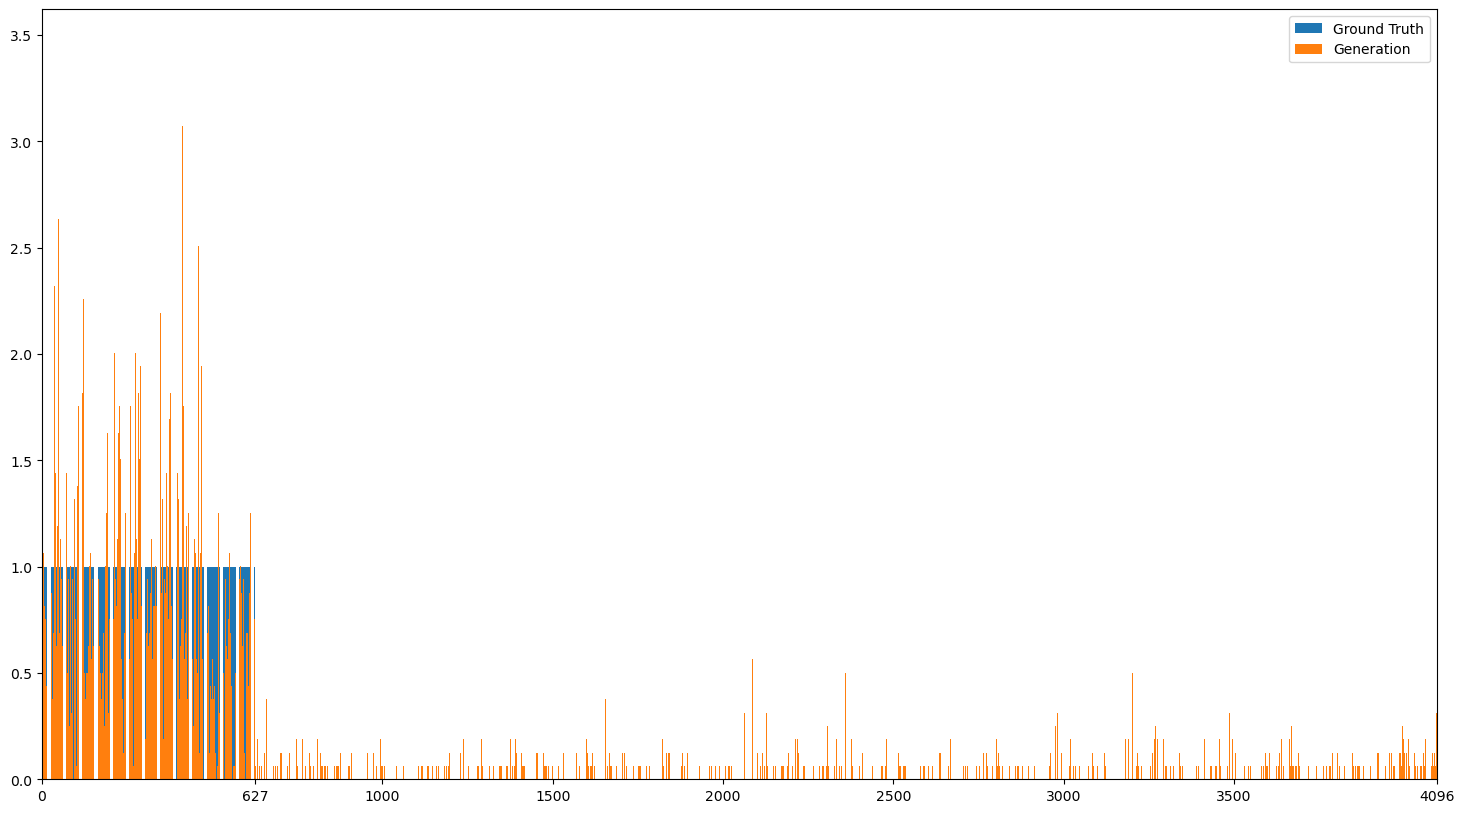

In [343]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [344]:
statistics

{'percent': 0.8083,
 'FN': array([ 38,  41,  74,  93, 123, 159, 163, 171, 183, 233, 241, 297, 383,
        395, 450, 475, 479, 481, 493, 494, 508, 513, 514, 515, 536, 555,
        560, 562, 564, 567, 572, 574, 594, 598, 600, 615, 618]),
 'n_fn': 37,
 'FP': array([[ 627,  629,  631, ..., 4093, 4094, 4095],
        [   1,    2,    1, ...,    1,    3,    5]], dtype=int64),
 'n_fp': 1192}

In [345]:
MSE

0.31989347

The result is too good. Maybe by self-organization we find a subspace of the entire space that fits the given Helmholtz machine structure best, so that it converges easily to this dataset. In the next notebook I will look closer to the internal structure of this model and see if there is an immediate answer.

For self-organizing system, we are not restricted to a fixed dataset. We can use pure samples as data in each updation, which forgets the original dataset as input.

In [372]:
para = np.load('self_org_parameters.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']
dataset = np.load('self_org_dataset.npy')
dataset.shape

(12, 627)

In [432]:
lr = 0.01
epoch = 10
n = n_dz[0,0]
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [455]:
update_rate = 100 # after how many epochs we update evidence
n_new_sample = 880 # how many samples are chosen as evidence at each update

In [456]:
for e in range(epoch):
    new_sampled = np.zeros((n,n_data*update_rate))
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for r in range (update_rate):
        index = np.random.permutation(n_data)
        for i in range(n_data):
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
            Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
            Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
            Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)

            new_sampled[:,i+n_data*r:i+n_data*r+1] = Alpha_P['z0']

            Loss_Q_total += Loss_Q
            Loss_P_total += Loss_P

    values,counts = np.unique(new_sampled,axis=1,return_counts = True)
    new_samples = values[:,np.argsort(counts)[-n_new_sample:]]
    
    if counts.size < n_new_sample:
        print('Number of samples reached system maximum')
        
    n_new_total = np.unique(np.append(dataset,new_samples,axis=1),axis=1).shape[1] - n_data
    dataset = new_samples  # renew dataset
    n_data = dataset.shape[1]

    Loss_Q_total = Loss_Q_total/(n_data*update_rate)
    Loss_P_total = Loss_P_total/(n_data*update_rate)
    print('New sampled: ' + str(n_new_total),'dataset size: ' + str(n_data),'Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

New sampled: 20 dataset size: 880 Loss_Q: [1.73 2.15 1.98 1.66 1.43 0.9  0.   9.85] Loss_P: [ 2.94  2.53  2.38  2.21  1.87  1.41  1.13 14.49]
New sampled: 8 dataset size: 880 Loss_Q: [ 1.74  2.2   2.05  1.71  1.49  0.97  0.   10.16] Loss_P: [ 3.01  2.57  2.45  2.31  1.92  1.49  1.21 14.95]
New sampled: 5 dataset size: 880 Loss_Q: [ 1.66  2.2   2.11  1.76  1.55  0.93  0.   10.21] Loss_P: [ 3.01  2.49  2.44  2.4   1.96  1.53  1.15 14.98]
New sampled: 1 dataset size: 880 Loss_Q: [1.6  2.19 2.11 1.71 1.47 0.87 0.   9.96] Loss_P: [ 2.99  2.44  2.46  2.42  1.85  1.48  1.08 14.72]
New sampled: 1 dataset size: 880 Loss_Q: [1.46 2.18 1.93 1.7  1.34 0.85 0.   9.47] Loss_P: [ 3.02  2.29  2.45  2.22  1.89  1.35  1.02 14.23]
New sampled: 0 dataset size: 880 Loss_Q: [1.5  2.1  2.06 1.68 1.38 1.05 0.   9.76] Loss_P: [ 3.    2.33  2.36  2.34  1.83  1.45  1.24 14.55]
New sampled: 0 dataset size: 880 Loss_Q: [1.61 1.96 1.93 1.62 1.42 0.98 0.   9.51] Loss_P: [ 2.95  2.45  2.23  2.2   1.83  1.46  1.18 14.

In [457]:
counts[np.argsort(counts)].size

1301

In [458]:
if counts.size < n_new_sample:
    print('Number of samples reached system maximum')

In [459]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
reordered_set = ut.reorder_all_comb(entire_set,dataset)
distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*n_data

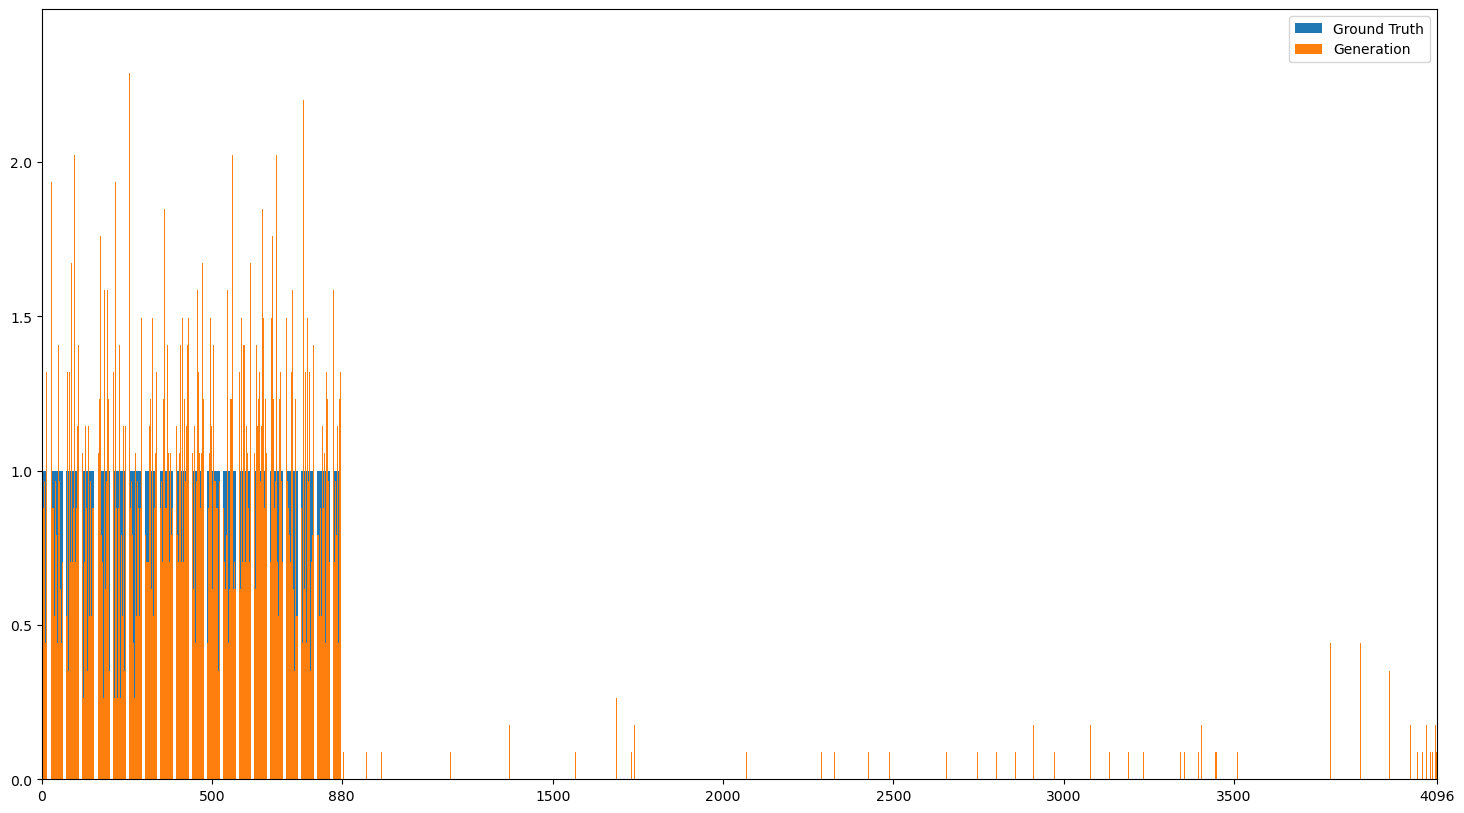

In [460]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [461]:
statistics

{'percent': 0.982,
 'FN': array([], dtype=int32),
 'n_fn': 0,
 'FP': array([[ 886,  893,  907,  953,  997, 1013, 1073, 1126, 1190, 1193, 1200,
         1207, 1246, 1260, 1267, 1311, 1325, 1373, 1387, 1447, 1486, 1553,
         1560, 1567, 1619, 1627, 1666, 1678, 1687, 1731, 1740, 1747, 1800,
         1807, 2068, 2069, 2137, 2181, 2289, 2327, 2422, 2427, 2464, 2489,
         2510, 2513, 2514, 2547, 2560, 2597, 2601, 2607, 2608, 2649, 2656,
         2687, 2747, 2803, 2859, 2866, 2871, 2911, 2912, 2918, 2922, 2923,
         2963, 2965, 2973, 3014, 3016, 3024, 3025, 3069, 3077, 3079, 3135,
         3191, 3235, 3247, 3291, 3333, 3343, 3344, 3355, 3395, 3396, 3405,
         3446, 3447, 3449, 3454, 3501, 3509, 3511, 3613, 3698, 3707, 3738,
         3744, 3745, 3784, 3791, 3833, 3872, 3879, 3950, 3957, 3968, 4012,
         4019, 4034, 4037, 4039, 4052, 4054, 4066, 4068, 4071, 4076, 4077,
         4083, 4084, 4087, 4092, 4095],
        [   1,    2,    1,    1,    1,    1,    1,    1,    1,    1

In [462]:
MSE

0.1298224

In [463]:
org_dataset = np.load('self_org_dataset.npy')
union = np.unique(np.append(dataset,org_dataset,axis=1),axis=1).shape[1]
intersection = dataset.shape[1] + org_dataset.shape[1] - union
intersection

537

percent: 0.9461, 0.9711,0.9784,0.9792,0.98,0.98,0.982

n_fn: 0,0,0,0,0,0,0

n_fp: 333,211,176,155,126,111,126

MSE: 0.1459,0.1451,0.1248,0.1175,0.1431,0.1254,0.1298

intersection (max 672): 532,537,535,535,536,536,537

In [465]:
union

970

In [466]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('self_org_dataset_98.npy',dataset)
np.save('self_org_parameters_98.npy',parameters)

For self-organizing system, we not only can extend upon an original samll subspace, as time goes by, some undersampled instances in the original set could also be discarded. By shifting from one space to another (with overlap), we find a better niche to fit.

In [12]:
para = np.load('self_org_parameters.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']
dataset = np.load('self_org_dataset.npy')
dataset.shape

(12, 627)

In [16]:
org_dataset = np.load('self_org_dataset.npy')

In [13]:
lr = 0.01
epoch = 10
n = n_dz[0,0]
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [36]:
update_rate = 100 # after how many epochs we update evidence
n_add_sample = 700
n_del_sample = 50

In [37]:
for e in range(epoch):
    new_sampled = np.zeros((n,n_data*update_rate))
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for r in range (update_rate):
        index = np.random.permutation(n_data)
        for i in range(n_data):
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
            Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
            Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
            Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)

            new_sampled[:,i+n_data*r:i+n_data*r+1] = Alpha_P['z0']

            Loss_Q_total += Loss_Q
            Loss_P_total += Loss_P

    values,counts = np.unique(new_sampled,axis=1,return_counts = True)
    n_new_total = np.unique(np.append(dataset,values,axis=1),axis=1).shape[1] - n_data
    
    new_samples = values[:,np.argsort(counts)[-n_add_sample:]]
    del_samples = values[:,np.argsort(counts)[n_del_sample:]]
    
    index = []
    for j in range(n_del_sample):
        for k in range(n_data):
            if np.array_equal(del_samples[:,j], dataset[:,k]):
                index.append(k)
                break
    dataset = np.delete(dataset,index,axis=1) # remove undersampled data points
    dataset = np.unique(np.append(dataset,new_samples,axis=1),axis=1)  # expand dataset        
    n_data = dataset.shape[1]

    Loss_Q_total = Loss_Q_total/(n_data*update_rate)
    Loss_P_total = Loss_P_total/(n_data*update_rate)
    print('Total new sampled: ' + str(n_new_total),'dataset size: ' + str(n_data),'delete samples: ' + str(len(index)))

Total new sampled: 2258 dataset size: 784 delete samples: 0
Total new sampled: 2231 dataset size: 789 delete samples: 1
Total new sampled: 2226 dataset size: 793 delete samples: 1
Total new sampled: 2188 dataset size: 799 delete samples: 1
Total new sampled: 2190 dataset size: 801 delete samples: 0
Total new sampled: 2198 dataset size: 801 delete samples: 0
Total new sampled: 2135 dataset size: 804 delete samples: 0
Total new sampled: 2192 dataset size: 808 delete samples: 0
Total new sampled: 2169 dataset size: 811 delete samples: 0
Total new sampled: 2151 dataset size: 814 delete samples: 0


In [31]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
reordered_set = ut.reorder_all_comb(entire_set,np.append(dataset,org_dataset,axis=1))
distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*n_data

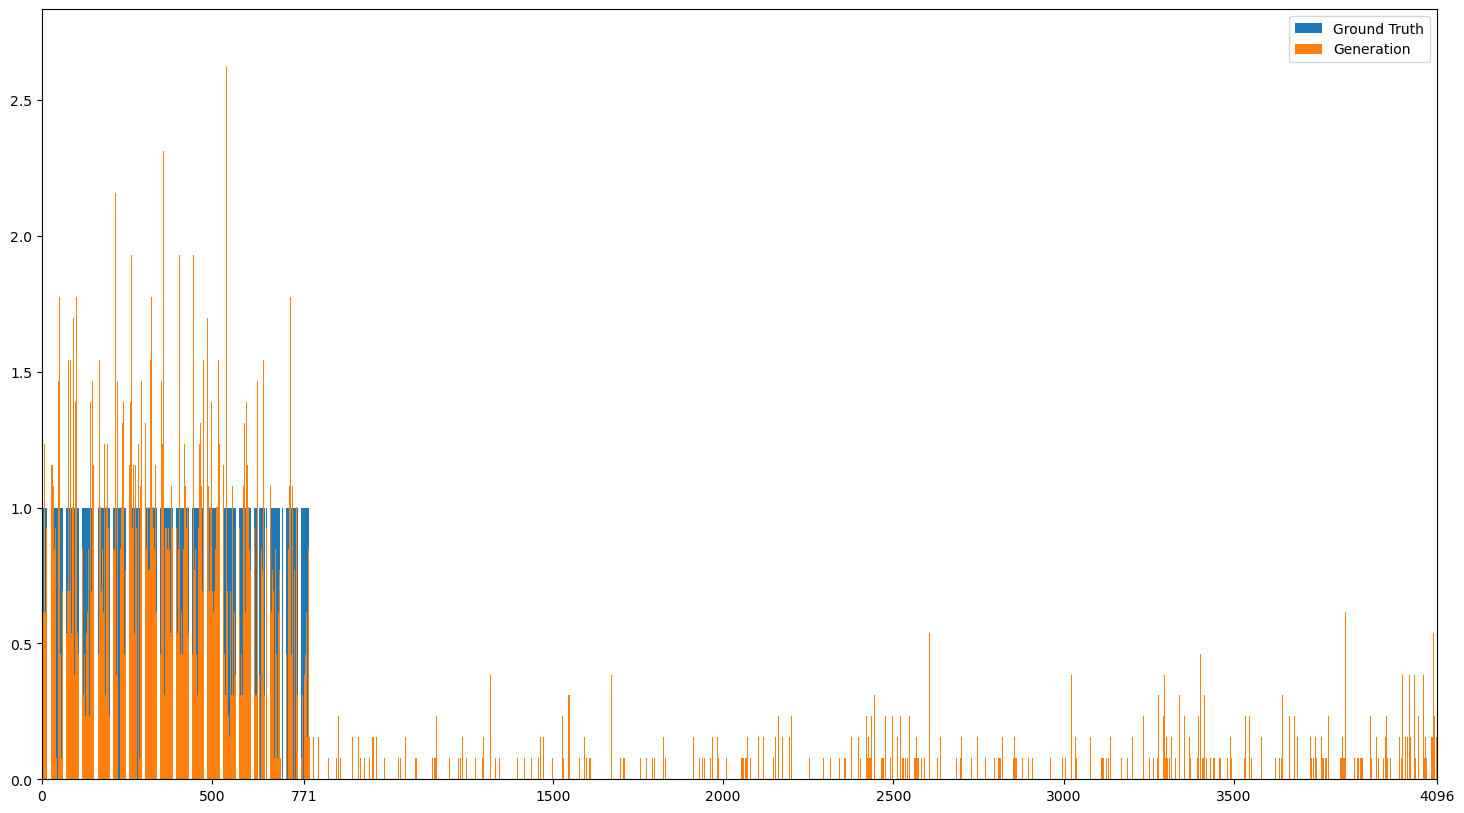

In [32]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [33]:
statistics

{'percent': 0.8323,
 'FN': array([ 18,  23,  46,  53,  86, 148, 153, 194, 209, 225, 228, 279, 281,
        346, 453, 465, 555, 562, 578, 581, 602, 621, 635, 636, 637, 640,
        642, 657, 662, 675, 687, 688, 693, 700, 704, 705, 706, 707, 708,
        717, 720, 721, 722, 739, 743, 745, 767, 768, 769]),
 'n_fn': 49,
 'FP': array([[ 771,  772,  773, ..., 4093, 4094, 4095],
        [   5,    8,   14, ...,    4,    1,    2]], dtype=int64),
 'n_fp': 929}

In [34]:
MSE

0.28591193000000004

'percent': 0.8111; 0.8234

n_fn': 33; 35

'n_fp': 1184; 1058

MSE: 0.2873; 0.3159